In [ ]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Mengunggah file kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/leukemia-classification --force

100% 866M/867M [00:32<00:00, 23.7MB/s]
100% 867M/867M [00:32<00:00, 28.1MB/s]


In [ ]:
!unzip leukemia-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_5_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_7_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_4_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_5_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/

In [ ]:
DATASET_PATH = "/content/C-NMC_Leukemia"
TRAINING_PATH = os.path.join(DATASET_PATH, 'training_data')

# Path untuk folder0
TRAINING_ALL_PATH_0 = os.path.join(TRAINING_PATH, 'fold_0', 'all')
TRAINING_HEM_PATH_0 = os.path.join(TRAINING_PATH, 'fold_0', 'hem')

# Path untuk folder1
TRAINING_ALL_PATH_1 = os.path.join(TRAINING_PATH, 'fold_1', 'all')
TRAINING_HEM_PATH_1 = os.path.join(TRAINING_PATH, 'fold_1', 'hem')

# Path untuk folder2
TRAINING_ALL_PATH_2 = os.path.join(TRAINING_PATH, 'fold_2', 'all')
TRAINING_HEM_PATH_2 = os.path.join(TRAINING_PATH, 'fold_2', 'hem')

# Path untuk folder validasi
VALIDATION_PATH = os.path.join(DATASET_PATH, 'validation_data', 'C-NMC_test_prelim_phase_data')

# Path untuk folder pengujian
TEST_PATH = os.path.join(DATASET_PATH, 'testing_data', 'C-NMC_test_final_phase_data')


LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/models/resnet-50"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
def set_seed ():
  '''
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  os.environ["PYTHONHASHSEED"]="0"
  np.random.seed(seed)
  rn.seed(seed)
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the training set
  '''
  return image_dataset_from_directory(
    os.path.join(TRAINING_PATH, 'fold_0'),
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle=True,  # Anda bisa menentukan apakah ingin mengacak urutan dataset atau tidak
    seed=123,  # Seed untuk pengacakan
  )

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the validation set
  '''
  return image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'validation_data'),
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle=True,  # Anda bisa menentukan apakah ingin mengacak urutan dataset atau tidak
    seed=123,  # Seed untuk pengacakan
  )

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the test set
  '''
  return image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'testing_data'),
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle=True,
    seed=123,
  )

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model(model):
    '''
    evaluate_model is used to plot some statistics about the performance on the test set
    :param model: model to consider
    '''
    y_score = model.predict(test_dataset)
    y_pred = np.rint(y_score)  # to have 0 or 1
    y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis=0)
    print("Classification report: ")
    print(metrics.classification_report(y_true, y_pred, digits=4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [ ]:
set_seed()

In [ ]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 3527 files belonging to 2 classes.
Found 1867 files belonging to 1 classes.
Found 2586 files belonging to 1 classes.


In [ ]:
conv_base = keras.applications.resnet.ResNet50(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                642259

Epoch 1/30
111/111 [==============================] - ETA: 0s - loss: 1.4591 - accuracy: 0.7908
Epoch 1: val_loss improved from inf to 0.24965, saving model to /content/models/experiment1_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 34s 197ms/step - loss: 1.4591 - accuracy: 0.7908 - val_loss: 0.2496 - val_accuracy: 0.9330
Epoch 2/30
110/111 [============================>.] - ETA: 0s - loss: 0.3649 - accuracy: 0.8474
Epoch 2: val_loss did not improve from 0.24965
111/111 [==============================] - 17s 148ms/step - loss: 0.3649 - accuracy: 0.8475 - val_loss: 0.6084 - val_accuracy: 0.7204
Epoch 3/30
110/111 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8634
Epoch 3: val_loss did not improve from 0.24965
111/111 [==============================] - 17s 150ms/step - loss: 0.3377 - accuracy: 0.8633 - val_loss: 0.3888 - val_accuracy: 0.8441
Epoch 4/30
110/111 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.8733
Epoch 4: val_loss did not improve from 0.24965
111/111 [==============================] - 21s 191ms/step - loss: 0.3077 - accuracy: 0.8733 - val_loss: 0.4379 - val_accuracy: 0.8152
Epoch 5/30
110/111 [===============

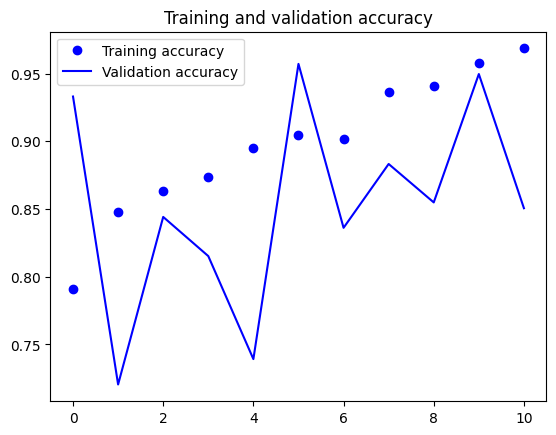

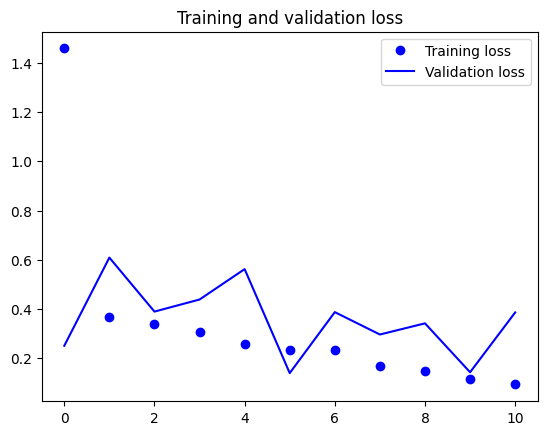

In [ ]:
run_model(model1, 'experiment1_feature_extraction', epochs = 30)

81/81 [==============================] - 9s 102ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.4876    0.6556      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.4876      2586
   macro avg     0.5000    0.2438    0.3278      2586
weighted avg     1.0000    0.4876    0.6556      2586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


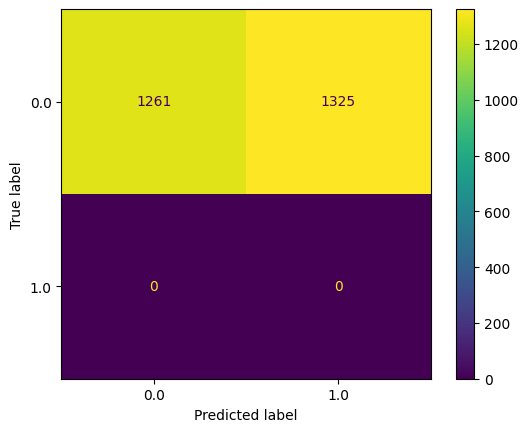

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5'))

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                3211

Epoch 1/30
110/111 [============================>.] - ETA: 0s - loss: 1.2374 - accuracy: 0.7830
Epoch 1: val_loss improved from inf to 0.04182, saving model to /content/models/experiment2_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 29s 199ms/step - loss: 1.2350 - accuracy: 0.7834 - val_loss: 0.0418 - val_accuracy: 0.9861
Epoch 2/30
110/111 [============================>.] - ETA: 0s - loss: 0.5009 - accuracy: 0.8409
Epoch 2: val_loss did not improve from 0.04182
111/111 [==============================] - 18s 150ms/step - loss: 0.5037 - accuracy: 0.8404 - val_loss: 0.1604 - val_accuracy: 0.9502
Epoch 3/30
110/111 [============================>.] - ETA: 0s - loss: 0.3742 - accuracy: 0.8815
Epoch 3: val_loss did not improve from 0.04182
111/111 [==============================] - 17s 153ms/step - loss: 0.3742 - accuracy: 0.8815 - val_loss: 0.4839 - val_accuracy: 0.8125
Epoch 4/30
110/111 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9145
Epoch 4: val_loss did not improve from 0.04182
111/111 [==============================] - 17s 154ms/step - loss: 0.2076 - accuracy: 0.9147 - val_loss: 0.6108 - val_accuracy: 0.7681
Epoch 5/30
110/111 [===============

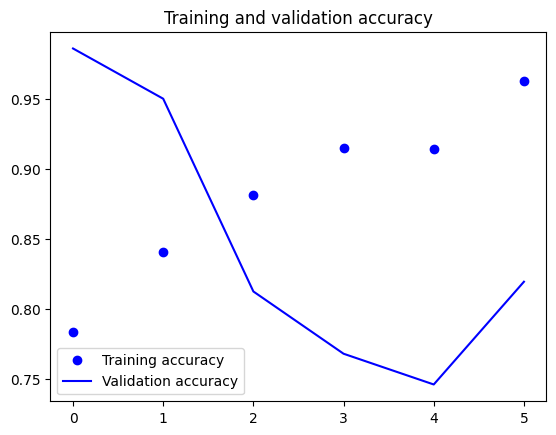

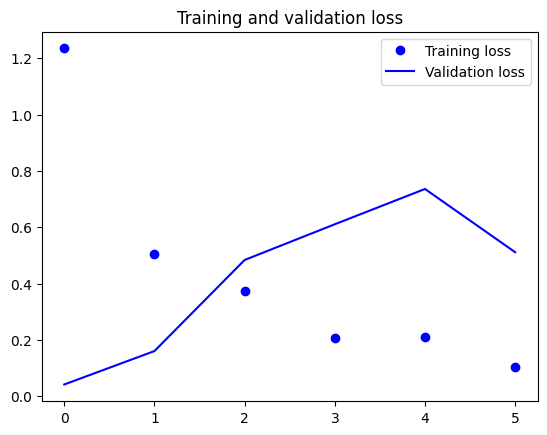

In [ ]:
run_model(model2, 'experiment2_feature_extraction', epochs = 30)

81/81 [==============================] - 21s 220ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.7119    0.8317      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.7119      2586
   macro avg     0.5000    0.3560    0.4159      2586
weighted avg     1.0000    0.7119    0.8317      2586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


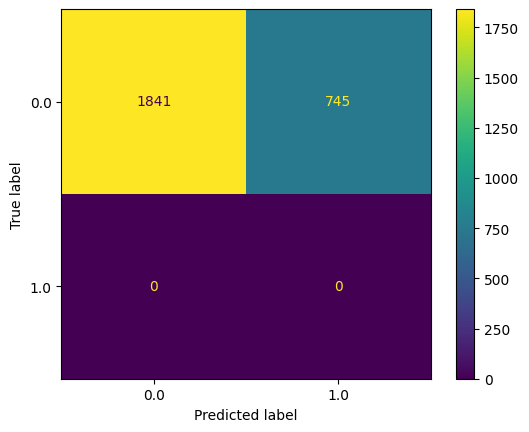

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction.h5'))

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                6422

Epoch 1/50
110/111 [============================>.] - ETA: 0s - loss: 0.9943 - accuracy: 0.7509
Epoch 1: val_loss improved from inf to 0.39529, saving model to /content/models/experiment3_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 31s 203ms/step - loss: 0.9929 - accuracy: 0.7511 - val_loss: 0.3953 - val_accuracy: 0.8425
Epoch 2/50
110/111 [============================>.] - ETA: 0s - loss: 0.4737 - accuracy: 0.7909
Epoch 2: val_loss improved from 0.39529 to 0.27065, saving model to /content/models/experiment3_feature_extraction.h5
111/111 [==============================] - 18s 162ms/step - loss: 0.4732 - accuracy: 0.7913 - val_loss: 0.2706 - val_accuracy: 0.9389
Epoch 3/50
110/111 [============================>.] - ETA: 0s - loss: 0.4267 - accuracy: 0.8085
Epoch 3: val_loss improved from 0.27065 to 0.21210, saving model to /content/models/experiment3_feature_extraction.h5
111/111 [==============================] - 18s 162ms/step - loss: 0.4270 - accuracy: 0.8083 - val_loss: 0.2121 - val_accuracy: 0.9534
Epoch 4/50
110/111 [============================>.] - ETA: 0s - loss: 0.3986 - accuracy: 0.8290
Epoch 4: val_loss did not improve from 0.21210
111/111 [==================

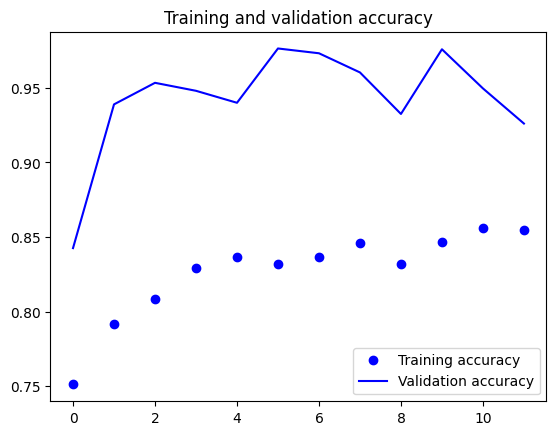

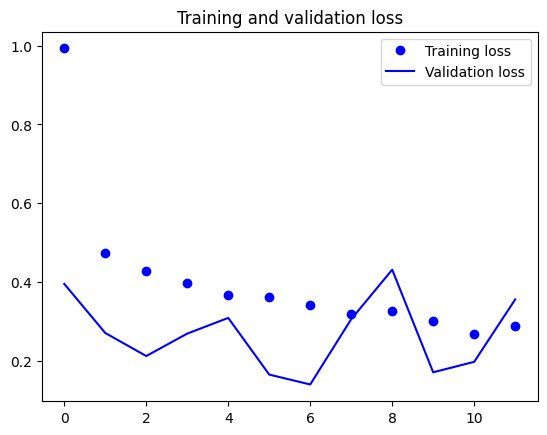

In [ ]:
run_model(model3, 'experiment3_feature_extraction', epochs = 50)

81/81 [==============================] - 17s 194ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.5998    0.7498      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.5998      2586
   macro avg     0.5000    0.2999    0.3749      2586
weighted avg     1.0000    0.5998    0.7498      2586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


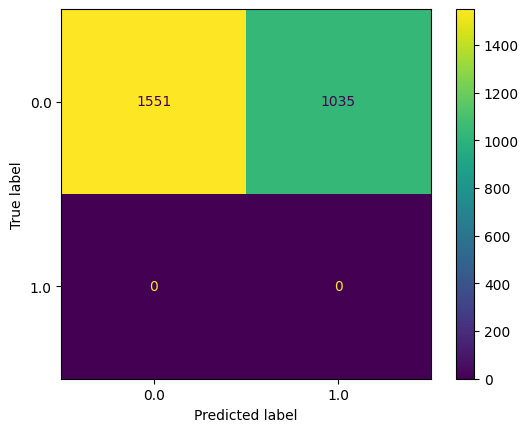

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction.h5'))